  Compare ocean magnitude between randomly sampled points to assess how much current magnitude deviation can be expected 
  between platform members of a seaweed robotic farm network

In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from ocean_navigation_simulator.environment.PlatformState import PlatformState
from ocean_navigation_simulator.data_sources.OceanCurrentField import OceanCurrentField
from ocean_navigation_simulator.utils import units

In [2]:
# For fast interpolation of currents we cache part of the spatio-temporal data around x_t in a casadi function
#%% Option 1: Accessing data in the Copernicus (or HYCOM) server directly via opendap -> data loaded when needed
casadi_cache_dict = {'deg_around_x_t': 1, 'time_around_x_t': 3600 * 24 * 1}
hindcast_source_dict = {'field': 'OceanCurrents',
                        'source': 'opendap',
                        'source_settings': {'service': 'copernicus',
                                            'currents': 'total',
                                            'USERNAME': 'mmariuswiggert', 'PASSWORD': 'tamku3-qetroR-guwneq',
                                            'DATASET_ID': 'cmems_mod_glo_phy_anfc_merged-uv_PT1H-i'}}
forecast_source_dict = None
#%% Create the ocean Field object (containing both the hindcast and optionally the forecast source)
ocean_field = OceanCurrentField(hindcast_source_dict=hindcast_source_dict,
                                forecast_source_dict=forecast_source_dict,
                                casadi_cache_dict=casadi_cache_dict)
t_0 = datetime.datetime(2021, 11, 25, 23, 30, tzinfo=datetime.timezone.utc)

In [3]:
def get_current_diff_over_points(xr_hindcast, nb_points):
    xr_dims = xr_hindcast.dims
    start_lon_idx = np.random.randint(0,xr_dims['lon'], nb_points)
    start_lat_idx = np.random.randint(0,xr_dims['lat'], nb_points)
    #start_points = xr_hindcast.isel(time=0, lon=slice(0,30), lat=slice(2,5))
    start_points = xr_hindcast[dict(lon=start_lon_idx, lat=start_lat_idx, time=[0])]
    end_lon_idx = np.random.randint(0,xr_dims['lon'], nb_points)
    end_lat_idx = np.random.randint(0,xr_dims['lat'], nb_points)
    #start_points = xr_hindcast.isel(time=0, lon=slice(0,30), lat=slice(2,5))
    end_points = xr_hindcast[dict(lon=end_lon_idx, lat=end_lat_idx, time=[0])]
    u_diff = start_points.water_u.to_numpy()-end_points.water_u.to_numpy()
    u_diff = u_diff.reshape(nb_points,nb_points)
    v_diff = start_points.water_v.to_numpy()-end_points.water_v.to_numpy()
    v_diff = v_diff.reshape(nb_points,nb_points)
    norm_diff = np.sqrt(u_diff**2+v_diff**2)
    coords_start_grid = np.asarray(np.meshgrid(start_points['lon'].values,start_points['lat'].values))
    coords_end_grid = np.asarray(np.meshgrid(end_points['lon'].values,end_points['lat'].values))
    lon_start = coords_start_grid[0].flatten()
    lat_start = coords_start_grid[1].flatten()
    lon_end = coords_end_grid[0].flatten()
    lat_end = coords_end_grid[1].flatten()
    dist_arr_deg = np.zeros(lon_start.size)
    for i in range(0,lon_start.size):
        Plat_starts = PlatformState(lon=units.Distance(deg=lon_start[i]), lat=units.Distance(deg=lat_start[i]))
        Plat_end = PlatformState(lon=units.Distance(deg=lon_end[i]), lat=units.Distance(deg=lat_end[i]))
        dist_arr_deg[i] =  Plat_starts.distance(Plat_end).deg
    return dist_arr_deg, norm_diff.flatten()

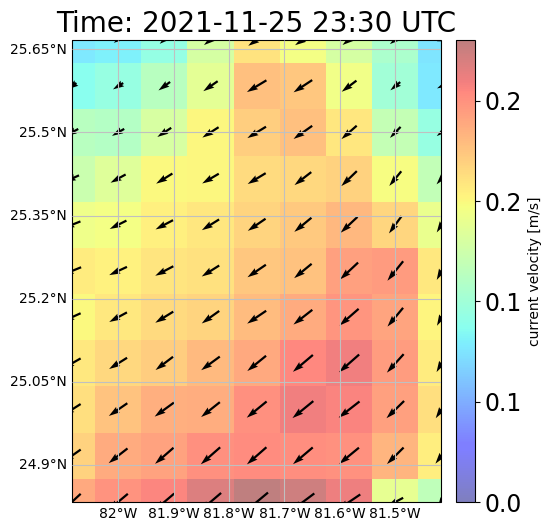

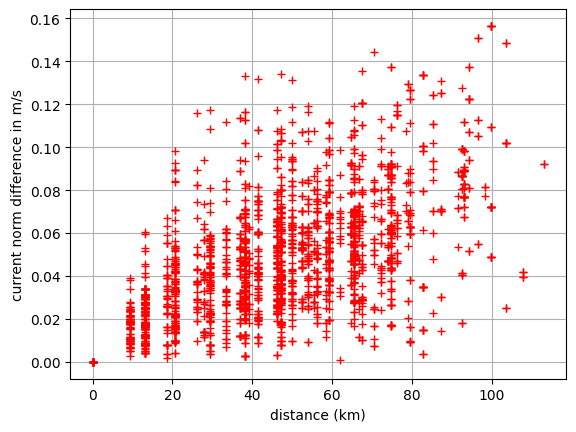

In [4]:
t_interval = [t_0, t_0 + datetime.timedelta(days=2)]
x_interval=[-82, -81.5]
y_interval=[25, 25.5]
hindcast_xarray = ocean_field.get_ground_truth_area(x_interval=x_interval, y_interval=y_interval, t_interval=t_interval)
#%% plot ocean currents at time over an area
ocean_field.hindcast_data_source.plot_data_at_time_over_area(
    time=t_0, x_interval=x_interval, y_interval=y_interval,
    # plot_type='streamline',
    plot_type='quiver',
    return_ax=False)
xr_dims = hindcast_xarray.dims
nb_points = 50
dist_arr_deg, norm_diff_flat = get_current_diff_over_points(hindcast_xarray,nb_points)
dist_arr_km =units.Distance(deg=dist_arr_deg).km 
plt.plot(dist_arr_km, norm_diff_flat, '+r')
plt.grid()
plt.xlabel("distance (km)")
plt.ylabel("current norm difference in m/s")
plt.show()


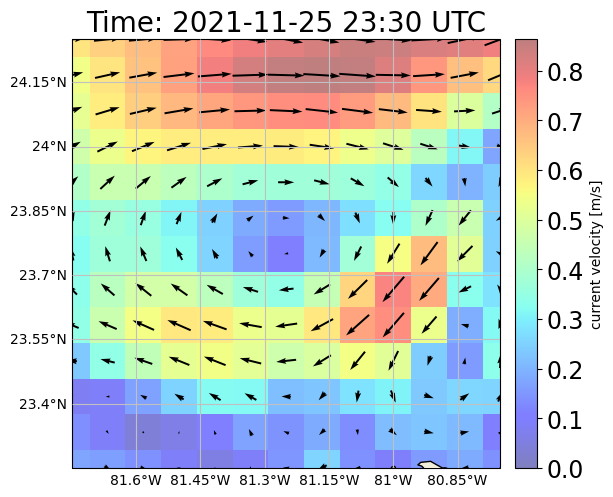

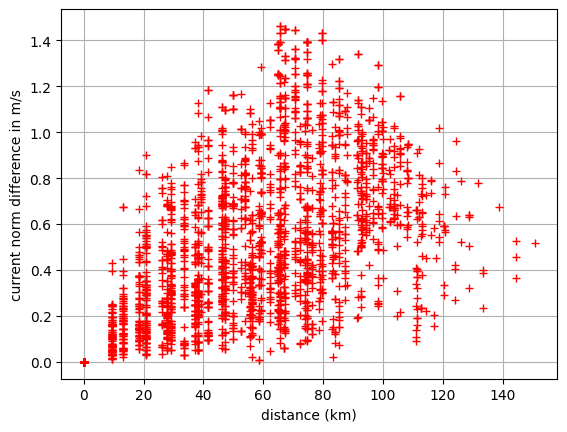

In [5]:
t_interval = [t_0, t_0 + datetime.timedelta(days=2)]
x_interval=[-81.6, -80.9]
y_interval=[23.4, 24.1]
hindcast_xarray = ocean_field.get_ground_truth_area(x_interval=x_interval, y_interval=y_interval, t_interval=t_interval)
#%% plot ocean currents at time over an area
ocean_field.hindcast_data_source.plot_data_at_time_over_area(
    time=t_0, x_interval=x_interval, y_interval=y_interval,
    # plot_type='streamline',
    plot_type='quiver',
    return_ax=False)
xr_dims = hindcast_xarray.dims
nb_points = 50
dist_arr_deg, norm_diff_flat = get_current_diff_over_points(hindcast_xarray,nb_points)
dist_arr_km =units.Distance(deg=dist_arr_deg).km 
plt.plot(dist_arr_km, norm_diff_flat, '+r')
plt.grid()
plt.xlabel("distance (km)")
plt.ylabel("current norm difference in m/s")
plt.show()